# Challenge Dados - 2ª Edição

## Importando bibliotecas

In [242]:
import pandas as pd
import numpy as np

import plotly.express as px
import seaborn as sns
import matplotlib.pyplot as plt

import time

from imblearn.over_sampling import SMOTE

from sklearn.dummy import DummyClassifier
#Algoritmos de bagging
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
#Algoritmos de boosting
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler

from joblib import dump, load

pd.options.display.max_columns = 999

SEED = 546

## Importando dados

In [58]:
df = pd.read_json('https://challenge-data-science-3ed.s3.amazonaws.com/Telco-Customer-Churn.json')


## Funções

In [59]:
def tabela_freq(df,variavel):
    
    df_freq = df[[variavel]].value_counts().to_frame('freq').reset_index()
    df_freq['percent'] = round(df_freq['freq'] / df_freq['freq'].sum(),4) * 100
    
    return df_freq


def tabela_freq_churn_variavel(df, variavel):

    df_freq = df[['churn', variavel]].value_counts().to_frame('freq').reset_index()
    df_freq['percent'] = round(df_freq['freq'] / df_freq['freq'].sum(), 4) * 100
    
    # Calcula a probabilidade de churn
    prob_churn = df.query("churn == 'Sim'").groupby(variavel)['churn'].count() / df.groupby(variavel)['churn'].count()
    prob_churn = prob_churn.reset_index().rename(columns={'churn': 'prob_churn'})
    prob_churn['prob_churn'] = prob_churn['prob_churn'].round(4) * 100
    
    df_freq = df_freq.merge(prob_churn, on=variavel, how='left')
    
    # Define a probabilidade de churn como 0 quando churn for "Não"
    df_freq.loc[df_freq['churn'] == 'Não', 'prob_churn'] = 0.0
    
    return df_freq

def avaliar_modelos(X, y, modelos):
    for nome_modelo, modelo in modelos:
        print(f"{5*'+-'} {nome_modelo} {5*'-+'}")

        cv = KFold(n_splits=5, shuffle=True)
        
        start_time = time.time()
        y_pred = cross_val_predict(modelo, X, y, cv=cv)

        auc_scorer = make_scorer(roc_auc_score)
        auc_scores = cross_val_score(modelo, X, y, cv=cv, scoring=auc_scorer)
        end_time = time.time()
        
        variacao_tempo = round(end_time-start_time,3)
        
        media_auc = auc_scores.mean()
        desvio_padrao_auc = auc_scores.std()
        
        auc_min = round((media_auc - (2 * desvio_padrao_auc)) * 100,2)
        auc_max = round((media_auc + (2 * desvio_padrao_auc)) * 100,2)
        variacao_do_intervalo = round(auc_max-auc_min,2)
    
        print('TEMPO = ',variacao_tempo,'\n')
        print('AUC =', media_auc.round(3))
        print('Variação do intervalo = ',variacao_do_intervalo)
    
        print("\nClassification Report:")
        print(classification_report(y, y_pred))
        
        print(20 * '-')

def pipeline_modelo_normalizado(modelo):
    
    scaler = MinMaxScaler()

    pipeline = Pipeline([('transformacao',scaler),('estimador',modelo)])
    
    return pipeline


# Semana 1

## Análise exploratória e transformações iniciais

In [60]:
df

,customerID,Churn,customer,phone,internet,account
0,0002-ORFBO,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
1,0003-MKNFE,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
2,0004-TLHLJ,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
3,0011-IGKFF,Yes,"{'gender': 'Male', 'SeniorCitizen': 1, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
4,0013-EXCHZ,Yes,"{'gender': 'Female', 'SeniorCitizen': 1, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
...,...,...,...,...,...,...
7262,9987-LUTYD,No,"{'gender': 'Female', 'SeniorCitizen': 0, 'Part...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'One year', 'PaperlessBilling': '..."
7263,9992-RRAMN,Yes,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'Yes'}","{'InternetService': 'Fiber optic', 'OnlineSecu...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
7264,9992-UJOEL,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Month-to-month', 'PaperlessBilli..."
7265,9993-LHIEB,No,"{'gender': 'Male', 'SeniorCitizen': 0, 'Partne...","{'PhoneService': 'Yes', 'MultipleLines': 'No'}","{'InternetService': 'DSL', 'OnlineSecurity': '...","{'Contract': 'Two year', 'PaperlessBilling': '..."


In [61]:
customer = pd.json_normalize(df['customer'])
phone = pd.json_normalize(df['phone'])
internet = pd.json_normalize(df['internet'])
account = pd.json_normalize(df['account'])

df_minimo = df[['customerID','Churn']]

df_normalizado = pd.concat([df_minimo,customer,phone,internet,account],axis=1)
df_normalizado

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.60,593.3
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.90,542.4
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.90,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.00,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.90,267.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,No,Female,0,No,No,13,Yes,No,DSL,Yes,No,No,Yes,No,No,One year,No,Mailed check,55.15,742.9
7263,9992-RRAMN,Yes,Male,0,Yes,No,22,Yes,Yes,Fiber optic,No,No,No,No,No,Yes,Month-to-month,Yes,Electronic check,85.10,1873.7
7264,9992-UJOEL,No,Male,0,No,No,2,Yes,No,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,50.30,92.75
7265,9993-LHIEB,No,Male,0,Yes,Yes,67,Yes,No,DSL,Yes,No,Yes,Yes,No,Yes,Two year,No,Mailed check,67.85,4627.65


In [62]:
#Verificando duplicatas
print(df_normalizado.duplicated().sum())
print(df_normalizado.customerID.duplicated().sum())

0
0


In [63]:
#Informações gerais
df_normalizado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   Partner           7267 non-null   object 
 5   Dependents        7267 non-null   object 
 6   tenure            7267 non-null   int64  
 7   PhoneService      7267 non-null   object 
 8   MultipleLines     7267 non-null   object 
 9   InternetService   7267 non-null   object 
 10  OnlineSecurity    7267 non-null   object 
 11  OnlineBackup      7267 non-null   object 
 12  DeviceProtection  7267 non-null   object 
 13  TechSupport       7267 non-null   object 
 14  StreamingTV       7267 non-null   object 
 15  StreamingMovies   7267 non-null   object 
 16  Contract          7267 non-null   object 


In [64]:
df_normalizado['Charges.Total'].value_counts()

Charges.Total
           11
20.2       11
19.75       9
19.55       9
19.9        9
           ..
272         1
1426.45     1
371.6       1
6786.4      1
3707.6      1
Name: count, Length: 6531, dtype: int64

In [65]:
#Ajustando incosistência e tipo do dado
df_normalizado['Charges.Total'] = df_normalizado['Charges.Total'].replace(' ','0')
df_normalizado['Charges.Total'] = df_normalizado['Charges.Total'].astype('float')

In [66]:
df_normalizado.head()

,customerID,Churn,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,Charges.Monthly,Charges.Total
0,0002-ORFBO,No,Female,0,Yes,Yes,9,Yes,No,DSL,No,Yes,No,Yes,Yes,No,One year,Yes,Mailed check,65.6,593.30
1,0003-MKNFE,No,Male,0,No,No,9,Yes,Yes,DSL,No,No,No,No,No,Yes,Month-to-month,No,Mailed check,59.9,542.40
2,0004-TLHLJ,Yes,Male,0,No,No,4,Yes,No,Fiber optic,No,No,Yes,No,No,No,Month-to-month,Yes,Electronic check,73.9,280.85
3,0011-IGKFF,Yes,Male,1,Yes,No,13,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,98.0,1237.85
4,0013-EXCHZ,Yes,Female,1,Yes,No,3,Yes,No,Fiber optic,No,No,No,Yes,Yes,No,Month-to-month,Yes,Mailed check,83.9,267.40


In [67]:
#Valores únicos de cada coluna
for i in df_normalizado[['Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total']]:
       print(10*'=','Coluna:', i,10*'=')
       print(df_normalizado[i].unique())
       print(100*'-','\n')

========== Coluna: Churn ==========
['No' 'Yes' '']
---------------------------------------------------------------------------------------------------- 

========== Coluna: gender ==========
['Female' 'Male']
---------------------------------------------------------------------------------------------------- 

========== Coluna: SeniorCitizen ==========
[0 1]
---------------------------------------------------------------------------------------------------- 

========== Coluna: Partner ==========
['Yes' 'No']
---------------------------------------------------------------------------------------------------- 

========== Coluna: Dependents ==========
['Yes' 'No']
---------------------------------------------------------------------------------------------------- 

========== Coluna: tenure ==========
[ 9  4 13  3 71 63  7 65 54 72  5 56 34  1 45 50 23 55 26 69 11 37 49 66
 67 20 43 59 12 27  2 25 29 14 35 64 39 40  6 30 70 57 58 16 32 33 10 21
 61 15 44 22 24 19 47 62 46 52  8 60 48 

In [68]:
#Excluindo linhas onde o churn é nulo, pois não será possível "classficar" o cliente
df_normalizado.Churn.replace('',None,inplace=True)
df_normalizado.dropna(inplace=True)

In [69]:
#Verificando valores modificados
print(df_normalizado.shape)
df_normalizado.Churn.value_counts(dropna=False)

(7043, 21)


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [70]:
#Entendendo a descrição estatística de forma geral
df_normalizado.describe().round(3)

,SeniorCitizen,tenure,Charges.Monthly,Charges.Total
count,7043.000,7043.000,7043.000,7043.000
mean,0.162,32.371,64.762,2279.734
std,0.369,24.559,30.090,2266.794
min,0.000,0.000,18.250,0.000
25%,0.000,9.000,35.500,398.550
50%,0.000,29.000,70.350,1394.550
75%,0.000,55.000,89.850,3786.600
max,1.000,72.000,118.750,8684.800


In [71]:
df_normalizado.columns

Index(['customerID', 'Churn', 'gender', 'SeniorCitizen', 'Partner',
       'Dependents', 'tenure', 'PhoneService', 'MultipleLines',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
       'PaperlessBilling', 'PaymentMethod', 'Charges.Monthly',
       'Charges.Total'],
      dtype='object')

In [72]:
#Traduzindo as colunas
df_normalizado.columns

df_normalizado.columns = ['customerID', 'churn', 'genero', 'idoso', 'tem_conjuge',
                          'tem_dependentes','meses_de_contrato', 'possui_servico_telefone', 'possui_multiplas_linhas',
                          'possui_servico_internet', 'possui_servico_seguranca_online', 'possui_servico_backup_online','possui_servico_protecao_dispositivo',
                          'possui_servico_suporte_tecnico','possui_TV_a_cabo', 'possui_TV_streaming', 'tipo_de_contrato',
                          'recebimento_de_fatura_online','forma_de_pagamento', 'fatura_mensal',
                          'total_gasto']

In [73]:
#Verificando valores colocados como "0" inicialmente na fatura total

teste = df_normalizado[['tipo_de_contrato','forma_de_pagamento','meses_de_contrato','fatura_mensal','total_gasto']]
teste.loc[:,'eh_fatura_total'] = teste.loc[:,'meses_de_contrato'] * teste.loc[:,'fatura_mensal']
teste.loc[:,'diff'] = teste.loc[:,'eh_fatura_total'] - teste.loc[:,'total_gasto']

teste

# O total gasto é o valor da fatura mensal pelos meses de contrato?

/tmp/ipykernel_3959/440007231.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_3959/440007231.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,tipo_de_contrato,forma_de_pagamento,meses_de_contrato,fatura_mensal,total_gasto,eh_fatura_total,diff
0,One year,Mailed check,9,65.60,593.30,590.40,-2.90
1,Month-to-month,Mailed check,9,59.90,542.40,539.10,-3.30
2,Month-to-month,Electronic check,4,73.90,280.85,295.60,14.75
3,Month-to-month,Electronic check,13,98.00,1237.85,1274.00,36.15
4,Month-to-month,Mailed check,3,83.90,267.40,251.70,-15.70
...,...,...,...,...,...,...,...
7262,One year,Mailed check,13,55.15,742.90,716.95,-25.95
7263,Month-to-month,Electronic check,22,85.10,1873.70,1872.20,-1.50
7264,Month-to-month,Mailed check,2,50.30,92.75,100.60,7.85
7265,Two year,Mailed check,67,67.85,4627.65,4545.95,-81.70


In [74]:
teste['diff'].describe() #Há uma considerável variação entre eles de forma geral

count    7043.000000
mean       -0.152953
std        67.202778
min      -373.250000
25%       -28.500000
50%         0.000000
75%        28.600000
max       370.850000
Name: diff, dtype: float64

In [75]:
teste.query('forma_de_pagamento == "Mailed check"')['diff'].describe() #Não tem um "padrão" devido a forma de pagamento

count    1612.000000
mean        0.391532
std        43.832980
min      -200.450000
25%       -14.487500
50%         0.000000
75%        15.062500
max       249.050000
Name: diff, dtype: float64

In [76]:
teste.query('forma_de_pagamento == "Electronic check"')['diff'].describe() #Não tem um "padrão" devido a forma de pagamento

count    2365.000000
mean       -1.187907
std        65.554589
min      -367.550000
25%       -25.650000
50%         0.000000
75%        26.500000
max       354.050000
Name: diff, dtype: float64

In [77]:
teste.query('tipo_de_contrato == "One year"')['diff'].describe() #Nem ao tipo de contrato

count    1473.000000
mean       -2.793924
std        76.182884
min      -367.550000
25%       -42.200000
50%        -0.600000
75%        39.950000
max       355.350000
Name: diff, dtype: float64

In [78]:
teste.query('tipo_de_contrato == "Month-to-month"')['diff'].describe() #Nem ao tipo de contrato

count    3875.000000
mean        0.860452
std        53.510590
min      -373.250000
25%       -16.875000
50%         0.000000
75%        19.250000
max       354.050000
Name: diff, dtype: float64

Como foi verificado, os valors preenchidos com "0" anteriormente, serão excluídos.

In [79]:
df_total_gasto_0 = df_normalizado.query('total_gasto == 0')

print('Quantidade de clientes = ', df_total_gasto_0.shape[0]) 



Quantidade de clientes =  11


In [80]:
df_normalizado_estruturado = df_normalizado.drop(labels=df_total_gasto_0.index)

In [81]:
df_normalizado_estruturado['idoso'] = df_normalizado_estruturado['idoso'].replace({0:'No',1:'Yes'}) #Padronizando formato de leitura inicial

In [82]:
df_normalizado_estruturado.tipo_de_contrato.unique()

array(['One year', 'Month-to-month', 'Two year'], dtype=object)

In [83]:
df_normalizado_estruturado.forma_de_pagamento.unique()

array(['Mailed check', 'Electronic check', 'Credit card (automatic)',
       'Bank transfer (automatic)'], dtype=object)

In [84]:
#Tradução dos dados para melhor visualização
df_normalizado_estruturado.replace({'No':'Não',
                                    'Yes':'Sim',
                                    'Fiber optic':'Fibra óptica',
                                    'One year':'Um ano',
                                    'Month-to-month':'Mês-a-mês',
                                    'Two year':'Dois anos',
                                    'Mailed check':'Cheque enviado',
                                    'Electronic check':'Cheque eletrônico',
                                    'No phone service':'Sem serviço de telefone',
                                    'No internet service':'Sem serviço de internet',
                                    'Credit card (automatic)':'Cartão de crédito (automático)',
                                    'Bank transfer (automatic)':'Transferência Bancária (Automática)',
                                    'Female':'Feminino',
                                    'Male':'Masculino'},inplace=True)

In [85]:
df_normalizado_estruturado

,customerID,churn,genero,idoso,tem_conjuge,tem_dependentes,meses_de_contrato,possui_servico_telefone,possui_multiplas_linhas,possui_servico_internet,possui_servico_seguranca_online,possui_servico_backup_online,possui_servico_protecao_dispositivo,possui_servico_suporte_tecnico,possui_TV_a_cabo,possui_TV_streaming,tipo_de_contrato,recebimento_de_fatura_online,forma_de_pagamento,fatura_mensal,total_gasto
0,0002-ORFBO,Não,Feminino,Não,Sim,Sim,9,Sim,Não,DSL,Não,Sim,Não,Sim,Sim,Não,Um ano,Sim,Cheque enviado,65.60,593.30
1,0003-MKNFE,Não,Masculino,Não,Não,Não,9,Sim,Sim,DSL,Não,Não,Não,Não,Não,Sim,Mês-a-mês,Não,Cheque enviado,59.90,542.40
2,0004-TLHLJ,Sim,Masculino,Não,Não,Não,4,Sim,Não,Fibra óptica,Não,Não,Sim,Não,Não,Não,Mês-a-mês,Sim,Cheque eletrônico,73.90,280.85
3,0011-IGKFF,Sim,Masculino,Sim,Sim,Não,13,Sim,Não,Fibra óptica,Não,Sim,Sim,Não,Sim,Sim,Mês-a-mês,Sim,Cheque eletrônico,98.00,1237.85
4,0013-EXCHZ,Sim,Feminino,Sim,Sim,Não,3,Sim,Não,Fibra óptica,Não,Não,Não,Sim,Sim,Não,Mês-a-mês,Sim,Cheque enviado,83.90,267.40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,9987-LUTYD,Não,Feminino,Não,Não,Não,13,Sim,Não,DSL,Sim,Não,Não,Sim,Não,Não,Um ano,Não,Cheque enviado,55.15,742.90
7263,9992-RRAMN,Sim,Masculino,Não,Sim,Não,22,Sim,Sim,Fibra óptica,Não,Não,Não,Não,Não,Sim,Mês-a-mês,Sim,Cheque eletrônico,85.10,1873.70
7264,9992-UJOEL,Não,Masculino,Não,Não,Não,2,Sim,Não,DSL,Não,Sim,Não,Não,Não,Não,Mês-a-mês,Sim,Cheque enviado,50.30,92.75
7265,9993-LHIEB,Não,Masculino,Não,Sim,Sim,67,Sim,Não,DSL,Sim,Não,Sim,Sim,Não,Sim,Dois anos,Não,Cheque enviado,67.85,4627.65


## Análise exploratória - Churn

In [86]:
tabela_freq(df_normalizado_estruturado,'churn') #Dados de target desbalanceados

,churn,freq,percent
0,Não,5163,73.42
1,Sim,1869,26.58


In [87]:
colunas_grafico = ['meses_de_contrato','fatura_mensal','total_gasto']

for coluna in colunas_grafico:
    fig = px.box(df_normalizado_estruturado, y=coluna, color='churn',
                 color_discrete_map={'Não': '#171821','Sim': '#fe3d67'},
                 points='all',
                 title=f'Frequência de {coluna} por Churn',
                 labels={'count':'Frequência'}, height=500)
    fig.update_yaxes(title_text='Frequência')
    
    fig.show()

Pode-se observar que a concentração de clientes com churn é mais alta, em contratos com uma duração menor (com uma mediana de 10 meses e um terceiro quartil de 29 meses).

Já em relação ao valor da fatura mensal, a maior ocorrência de churn é em casos onde o valor é mais alto (com uma mediana de 79,65 e um 3 quartil de 94,21).

Como o total gasto está atrelado ao tempo de duração do contrato (mesmo que sem uma razão padronizada identificada), obviamente os casos de churn positivo estão com valores menores (mediana de 703,55 e 3 quartil de 2.332,30).

In [88]:
colunas_grafico = ['genero', 'idoso', 'tem_conjuge', 'tem_dependentes', 'meses_de_contrato','possui_servico_telefone',
                   'possui_multiplas_linhas','possui_servico_internet','possui_servico_seguranca_online','possui_servico_backup_online',
                   'possui_servico_protecao_dispositivo','possui_servico_suporte_tecnico','possui_TV_a_cabo','possui_TV_streaming','tipo_de_contrato',
                   'recebimento_de_fatura_online','forma_de_pagamento','fatura_mensal','total_gasto']

for coluna in colunas_grafico:
    fig = px.histogram(df_normalizado_estruturado, x=coluna, color='churn',               
                       color_discrete_map={'Não': '#171821','Sim': '#fe3d67'},
                       barmode='group', 
                       title=f'Frequência de {coluna} por Churn',
                       labels={'count':'Frequência'}, height=500)
    fig.update_yaxes(title_text='Frequência')

    fig.show()
    
    print(10*'-',f'Tabela de frequẽncia de {coluna}',10*'-')
    print(tabela_freq_churn_variavel(df_normalizado_estruturado,coluna))


---------- Tabela de frequẽncia de genero ----------
  churn     genero  freq  percent  prob_churn
0   Não  Masculino  2619    37.24        0.00
1   Não   Feminino  2544    36.18        0.00
2   Sim   Feminino   939    13.35       26.96
3   Sim  Masculino   930    13.23       26.20


---------- Tabela de frequẽncia de idoso ----------
  churn idoso  freq  percent  prob_churn
0   Não   Não  4497    63.95        0.00
1   Sim   Não  1393    19.81       23.65
2   Não   Sim   666     9.47        0.00
3   Sim   Sim   476     6.77       41.68


---------- Tabela de frequẽncia de tem_conjuge ----------
  churn tem_conjuge  freq  percent  prob_churn
0   Não         Sim  2724    38.74        0.00
1   Não         Não  2439    34.68        0.00
2   Sim         Não  1200    17.06       32.98
3   Sim         Sim   669     9.51       19.72


---------- Tabela de frequẽncia de tem_dependentes ----------
  churn tem_dependentes  freq  percent  prob_churn
0   Não             Não  3390    48.21        0.00
1   Não             Sim  1773    25.21        0.00
2   Sim             Não  1543    21.94       31.28
3   Sim             Sim   326     4.64       15.53


---------- Tabela de frequẽncia de meses_de_contrato ----------
    churn  meses_de_contrato  freq  percent  prob_churn
0     Sim                  1   380     5.40       61.99
1     Não                 72   356     5.06        0.00
2     Não                  1   233     3.31        0.00
3     Não                 71   164     2.33        0.00
4     Sim                  2   123     1.75       51.68
..    ...                ...   ...      ...         ...
139   Sim                 45     6     0.09        9.84
140   Sim                 60     6     0.09        7.89
141   Sim                 62     5     0.07        7.14
142   Sim                 64     4     0.06        5.00
143   Sim                 63     4     0.06        5.56

[144 rows x 5 columns]


---------- Tabela de frequẽncia de possui_servico_telefone ----------
  churn possui_servico_telefone  freq  percent  prob_churn
0   Não                     Sim  4653    66.17        0.00
1   Sim                     Sim  1699    24.16       26.75
2   Não                     Não   510     7.25        0.00
3   Sim                     Não   170     2.42       25.00


---------- Tabela de frequẽncia de possui_multiplas_linhas ----------
  churn  possui_multiplas_linhas  freq  percent  prob_churn
0   Não                      Não  2536    36.06        0.00
1   Não                      Sim  2117    30.11        0.00
2   Sim                      Sim   850    12.09       28.65
3   Sim                      Não   849    12.07       25.08
4   Não  Sem serviço de telefone   510     7.25        0.00
5   Sim  Sem serviço de telefone   170     2.42       25.00


---------- Tabela de frequẽncia de possui_servico_internet ----------
  churn possui_servico_internet  freq  percent  prob_churn
0   Não                     DSL  1957    27.83        0.00
1   Não            Fibra óptica  1799    25.58        0.00
2   Não                     Não  1407    20.01        0.00
3   Sim            Fibra óptica  1297    18.44       41.89
4   Sim                     DSL   459     6.53       19.00
5   Sim                     Não   113     1.61        7.43


---------- Tabela de frequẽncia de possui_servico_seguranca_online ----------
  churn possui_servico_seguranca_online  freq  percent  prob_churn
0   Não                             Não  2036    28.95        0.00
1   Não                             Sim  1720    24.46        0.00
2   Sim                             Não  1461    20.78       41.78
3   Não         Sem serviço de internet  1407    20.01        0.00
4   Sim                             Sim   295     4.20       14.64
5   Sim         Sem serviço de internet   113     1.61        7.43


---------- Tabela de frequẽncia de possui_servico_backup_online ----------
  churn possui_servico_backup_online  freq  percent  prob_churn
0   Não                          Sim  1902    27.05        0.00
1   Não                          Não  1854    26.37        0.00
2   Não      Sem serviço de internet  1407    20.01        0.00
3   Sim                          Não  1233    17.53       39.94
4   Sim                          Sim   523     7.44       21.57
5   Sim      Sem serviço de internet   113     1.61        7.43


---------- Tabela de frequẽncia de possui_servico_protecao_dispositivo ----------
  churn possui_servico_protecao_dispositivo  freq  percent  prob_churn
0   Não                                 Não  1883    26.78        0.00
1   Não                                 Sim  1873    26.64        0.00
2   Não             Sem serviço de internet  1407    20.01        0.00
3   Sim                                 Não  1211    17.22       39.14
4   Sim                                 Sim   545     7.75       22.54
5   Sim             Sem serviço de internet   113     1.61        7.43


---------- Tabela de frequẽncia de possui_servico_suporte_tecnico ----------
  churn possui_servico_suporte_tecnico  freq  percent  prob_churn
0   Não                            Não  2026    28.81        0.00
1   Não                            Sim  1730    24.60        0.00
2   Sim                            Não  1446    20.56       41.65
3   Não        Sem serviço de internet  1407    20.01        0.00
4   Sim                            Sim   310     4.41       15.20
5   Sim        Sem serviço de internet   113     1.61        7.43


---------- Tabela de frequẽncia de possui_TV_a_cabo ----------
  churn         possui_TV_a_cabo  freq  percent  prob_churn
0   Não                      Sim  1889    26.86        0.00
1   Não                      Não  1867    26.55        0.00
2   Não  Sem serviço de internet  1407    20.01        0.00
3   Sim                      Não   942    13.40       33.54
4   Sim                      Sim   814    11.58       30.11
5   Sim  Sem serviço de internet   113     1.61        7.43


---------- Tabela de frequẽncia de possui_TV_streaming ----------
  churn      possui_TV_streaming  freq  percent  prob_churn
0   Não                      Sim  1913    27.20        0.00
1   Não                      Não  1843    26.21        0.00
2   Não  Sem serviço de internet  1407    20.01        0.00
3   Sim                      Não   938    13.34       33.73
4   Sim                      Sim   818    11.63       29.95
5   Sim  Sem serviço de internet   113     1.61        7.43


---------- Tabela de frequẽncia de tipo_de_contrato ----------
  churn tipo_de_contrato  freq  percent  prob_churn
0   Não        Mês-a-mês  2220    31.57        0.00
1   Sim        Mês-a-mês  1655    23.54       42.71
2   Não        Dois anos  1637    23.28        0.00
3   Não           Um ano  1306    18.57        0.00
4   Sim           Um ano   166     2.36       11.28
5   Sim        Dois anos    48     0.68        2.85


---------- Tabela de frequẽncia de recebimento_de_fatura_online ----------
  churn recebimento_de_fatura_online  freq  percent  prob_churn
0   Não                          Sim  2768    39.36        0.00
1   Não                          Não  2395    34.06        0.00
2   Sim                          Sim  1400    19.91       33.59
3   Sim                          Não   469     6.67       16.38


---------- Tabela de frequẽncia de forma_de_pagamento ----------
  churn                   forma_de_pagamento  freq  percent  prob_churn
0   Não                       Cheque enviado  1296    18.43        0.00
1   Não                    Cheque eletrônico  1294    18.40        0.00
2   Não       Cartão de crédito (automático)  1289    18.33        0.00
3   Não  Transferência Bancária (Automática)  1284    18.26        0.00
4   Sim                    Cheque eletrônico  1071    15.23       45.29
5   Sim                       Cheque enviado   308     4.38       19.20
6   Sim  Transferência Bancária (Automática)   258     3.67       16.73
7   Sim       Cartão de crédito (automático)   232     3.30       15.25


---------- Tabela de frequẽncia de fatura_mensal ----------
     churn  fatura_mensal  freq  percent  prob_churn
0      Não          20.05    58     0.82         0.0
1      Não          19.95    41     0.58         0.0
2      Não          19.90    40     0.57         0.0
3      Não          19.70    40     0.57         0.0
4      Não          20.00    39     0.55         0.0
...    ...            ...   ...      ...         ...
2364   Não         114.85     1     0.01         0.0
2365   Não         114.75     1     0.01         0.0
2366   Não         114.70     1     0.01         0.0
2367   Não         114.55     1     0.01         0.0
2368   Sim         118.35     1     0.01       100.0

[2369 rows x 5 columns]


---------- Tabela de frequẽncia de total_gasto ----------
     churn  total_gasto  freq  percent  prob_churn
0      Não        19.75     7     0.10        0.00
1      Não        20.05     6     0.09        0.00
2      Sim        20.20     6     0.09       54.55
3      Não        19.65     6     0.09        0.00
4      Não        19.55     6     0.09        0.00
...    ...          ...   ...      ...         ...
6692   Não      1558.70     1     0.01        0.00
6693   Não      1558.65     1     0.01        0.00
6694   Não      1556.85     1     0.01        0.00
6695   Não      1554.90     1     0.01        0.00
6696   Sim      8684.80     1     0.01      100.00

[6697 rows x 5 columns]


Em relação ao gênero, a distribuição entre os gênero se equivaleram, tornando-se assim uma variável possivelmente irrelevante para a identificação do churn.

Já dentre a variável se é uma pessoa idosa ou não, houve uma distribuição significativa. Pessoas idosas possuem uma maior probabilidade de churn, quando comparadas a pessoas não idosas.

Assim como em casos onde a pessoa tem cônjuge ou não, e se tem dependentes ou não. Quando não tem cônjuge a probabilidade de churn é maior, assim como quando não tem dependentes.

Claramente é possível observar no gráfico que a frequência de churn positivo/negativo é inversamente proporcional a duração do tempo de contrato. No qual tempos de contrato com uma duração entre 0-1 meses, tem uma maior probabilidade de churn (62%), e contratos com 72-73 meses, tem uma menor probabilidade (9,8%).

Dentre as variáveis se possuem serviço de telefone e múltiplas linhas, a probabilidade de churn se mostrou praticamente que semelhante, levando possibilidade de exclusão delas, para não prejudicar o modelo a ser treinado.

Se possui serviço de internet, foi uma identificado uma variável importante, mostrando que a proabilidade de churn é maior dentre os de "Fibra óptica", "DSL"  e "Não" possui serviço. Além disso, pode-se visualizar que a proporção dentre os que não possuem serviço é mais determinante em relação ao churn positivo ou negativo (caso não possua, é menos provável que haja churn).

Serviço de segurança online, serviço de backup online, serviço de proteção do dispositivo e serviço de suporte técnico, apresentaram resultados semelhantes, com uma variável mais provável de churn e outra com uma proporção mais determinante.

As variáveis em relação ao serviço de TV (cabo ou streaming) tiveram probabilidades de churn semelhantes em casos de respostas (sim ou não) e uma menor probabilidade, quando não havia serviço de internet.

O tipo de contrato, teve uma maior probabilidade de churn para "mês-a-mês", "um ano" e "dois anos", apresentando maior ênfase determinantes em variáveis como "um ano" e "dois anos". Isso destaca a importância de considerar a duração do contrato ao analisar o churn, já que contratos de longo prazo, embora com probabilidade menor de churn, ainda podem contribuir para as taxas gerais.

Entre a frequência de recebimento de fatura online, a maior probabilidade de churn foi "com recebimento de fatura", e uma maior determinação dentre os que "Não" recebem fatura online.

A forma de pagamento em "cheque eletrônico" foi a que teve uma maior probabilidade de churn, entretanto, as demais "Cheque enviado", "Cartão de crédito (automático)" e "Transferência Bancária (Automática)" apresentaram maior distinção entre churn e "não churn".

O valor da fatura mensal, apresenta um baixo percentual de churn quando é em valores menores de 45, e aumenta até a faixa de 100-110, entretanto não há uma proporção maiis significativa dentre essas faixas.

Já dentre o total gasto, a probabilidade de churn foi diminuindo com o crescimento do gasto (considerando que este valor está ligado ao tempo de contrato).

Em síntese, a análise dos diversos atributos revela nuances importantes relacionadas ao churn. Enquanto alguns fatores, como gênero, têm pouca influência na probabilidade de churn, outros, como idade, tipo de contrato e presença de serviços específicos, demonstram impactos significativos. A duração do contrato surge como um elemento crucial, com contratos de curto prazo exibindo maior probabilidade de churn, porém mesmo contratos mais longos não estão imunes a esse fenômeno. Compreender essas relações permite a empresa aprimorar suas estratégias de retenção, personalizando abordagens para minimizar o churn e otimizar a satisfação do cliente.

## Normalização das variáveis

In [89]:
df_normalizado_estruturado.possui_multiplas_linhas.unique()

array(['Não', 'Sim', 'Sem serviço de telefone'], dtype=object)

In [90]:
df_variaveis_normalizadas = df_normalizado_estruturado.drop(columns='customerID').copy()

variaveis_numericas = df_variaveis_normalizadas[['meses_de_contrato','fatura_mensal','total_gasto']]

variaveis_binarias = df_variaveis_normalizadas[['churn','idoso','tem_conjuge','tem_dependentes','possui_servico_telefone']].replace({'Não':0,'Sim':1})

variaveis_multiplas = df_variaveis_normalizadas[['genero','possui_multiplas_linhas','possui_servico_internet','possui_servico_seguranca_online',
                           'possui_servico_backup_online','possui_servico_protecao_dispositivo','possui_servico_suporte_tecnico',
                           'possui_TV_a_cabo','possui_TV_streaming','tipo_de_contrato','forma_de_pagamento']]

variaveis_multiplas_normalizadas = pd.get_dummies(variaveis_multiplas,dtype=int)


In [91]:
df_final = pd.concat([variaveis_binarias,variaveis_numericas,variaveis_multiplas_normalizadas],axis=1)

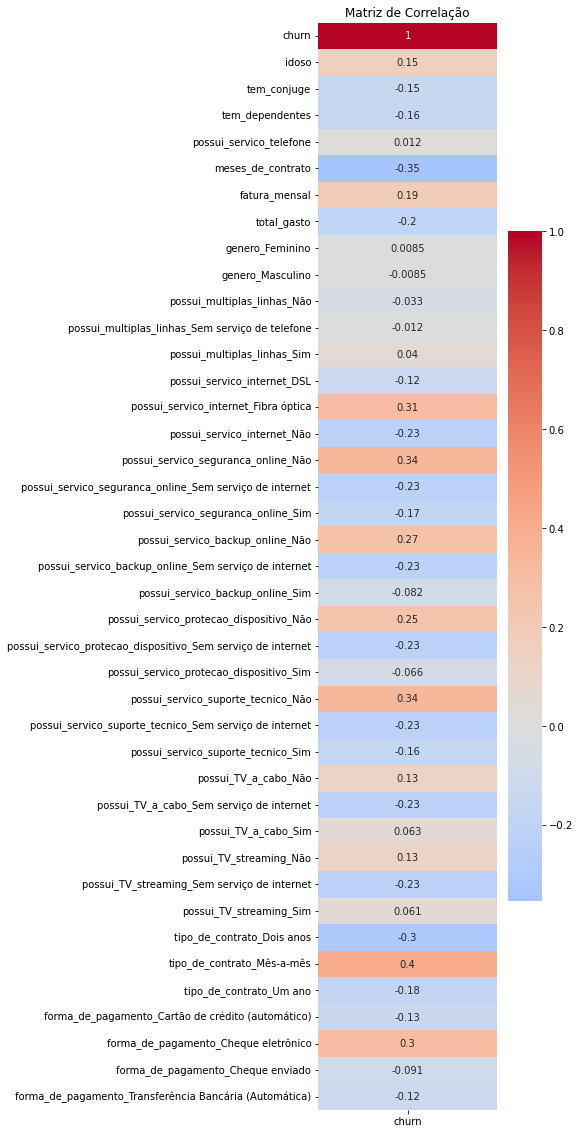

In [92]:
matriz_corr = df_final.corr()

# Cria um heatmap
plt.figure(figsize=(4, 20))
sns.heatmap(matriz_corr.loc[:,['churn']], annot=True, cmap='coolwarm', center=0)
plt.title('Matriz de Correlação')
plt.show()

In [93]:
df_final.drop(columns=[
    'possui_servico_telefone','genero_Feminino', 'genero_Masculino',
    'possui_multiplas_linhas_Não',
    'possui_multiplas_linhas_Sem serviço de telefone',
    'possui_multiplas_linhas_Sim'],
    inplace=True)

In [94]:
df_final

,churn,idoso,tem_conjuge,tem_dependentes,meses_de_contrato,fatura_mensal,total_gasto,possui_servico_internet_DSL,possui_servico_internet_Fibra óptica,possui_servico_internet_Não,possui_servico_seguranca_online_Não,possui_servico_seguranca_online_Sem serviço de internet,possui_servico_seguranca_online_Sim,possui_servico_backup_online_Não,possui_servico_backup_online_Sem serviço de internet,possui_servico_backup_online_Sim,possui_servico_protecao_dispositivo_Não,possui_servico_protecao_dispositivo_Sem serviço de internet,possui_servico_protecao_dispositivo_Sim,possui_servico_suporte_tecnico_Não,possui_servico_suporte_tecnico_Sem serviço de internet,possui_servico_suporte_tecnico_Sim,possui_TV_a_cabo_Não,possui_TV_a_cabo_Sem serviço de internet,possui_TV_a_cabo_Sim,possui_TV_streaming_Não,possui_TV_streaming_Sem serviço de internet,possui_TV_streaming_Sim,tipo_de_contrato_Dois anos,tipo_de_contrato_Mês-a-mês,tipo_de_contrato_Um ano,forma_de_pagamento_Cartão de crédito (automático),forma_de_pagamento_Cheque eletrônico,forma_de_pagamento_Cheque enviado,forma_de_pagamento_Transferência Bancária (Automática)
0,0,0,1,1,9,65.60,593.30,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0
1,0,0,0,0,9,59.90,542.40,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0
2,1,0,0,0,4,73.90,280.85,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0
3,1,1,1,0,13,98.00,1237.85,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0
4,1,1,1,0,3,83.90,267.40,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7262,0,0,0,0,13,55.15,742.90,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,0,0,1,0,0,1,0
7263,1,0,1,0,22,85.10,1873.70,0,1,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0
7264,0,0,0,0,2,50.30,92.75,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0,1,0
7265,0,0,1,1,67,67.85,4627.65,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,1,0,0,0,0,1,0


# Semana 2

## Balanceamento da variável target

In [95]:
print(df_final['churn'].value_counts())
print(df_final['churn'].value_counts(normalize=True))

churn
0    5163
1    1869
Name: count, dtype: int64
churn
0    0.734215
1    0.265785
Name: proportion, dtype: float64


Dados desbalanceados. 

Por isso realizarei o balanceamento, utilizando o SMOTE (devido a sua capacidade de gerar novas amostras por interpolação e, consequentemente, uma variabilidade mais natural nos dados sintéticos, do que apenas uma duplicação dos dados minoritários).

In [96]:
X = df_final.drop('churn', axis = 1)
y = df_final['churn']

smt = SMOTE(random_state=645)  
X, y = smt.fit_resample(X, y)  # Reamostragem

df_final_balanceado = pd.concat([X, y], axis=1)  


In [97]:
print(df_final_balanceado['churn'].value_counts())
print(df_final_balanceado['churn'].value_counts(normalize=True))

churn
0    5163
1    5163
Name: count, dtype: int64
churn
0    0.5
1    0.5
Name: proportion, dtype: float64


## Modelos de ML

A normalização de dados é necessária em alguns modelos de ML para garantir que eles não sejam sensíveis a valores discrepantes ao atribuir pesos nas decisões. Portanto, realizarei a normalização dos dados em alguns modelos e em outros não, de acordo com as seguintes categorias:

Modelos sem normalização:
- RandomForestClassifier
- ExtraTreesClassifier

Modelos com normalização:
- KNeighborsClassifier e BaggingClassifier (embora o Bagging seja usado como técnica de ensemble e não exija normalização, o KNeighborsClassifier requer normalização)
- AdaBoostClassifier
- HistGradientBoostingClassifier

Isso garantirá que os modelos sensíveis a valores discrepantes se beneficiem da normalização, enquanto os modelos menos afetados por esses valores podem funcionar sem ela.


In [129]:
modelos = [
    ('DUMMY CLASSIFIER', DummyClassifier(strategy="most_frequent",random_state=SEED)),
    ('RANDOM FOREST CLASSIFIER', RandomForestClassifier(random_state=SEED)),
    ('EXTRA TREES CLASSIFIER',ExtraTreesClassifier(random_state=SEED)),
    ('BAGGING - KNN CLASSIFIER', pipeline_modelo_normalizado(BaggingClassifier(KNeighborsClassifier(),random_state=SEED))),
    ('BAGGING - SVC CLASSIFIER', pipeline_modelo_normalizado(BaggingClassifier(SVC(random_state=SEED),random_state=SEED))),
    ('ADA BOOST CLASSIFIER', pipeline_modelo_normalizado(AdaBoostClassifier(random_state=SEED))),
    ('HIST GRADIENT BOOSTING CLASSIFIER', pipeline_modelo_normalizado(HistGradientBoostingClassifier(random_state=SEED)))
]

In [130]:
avaliar_modelos(X,y,modelos)

+-+-+-+-+- DUMMY CLASSIFIER -+-+-+-+-+
TEMPO =  0.079
AUC = 0.5
Variação do intervalo =  0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.39      0.44      5163
           1       0.49      0.59      0.54      5163

    accuracy                           0.49     10326
   macro avg       0.49      0.49      0.49     10326
weighted avg       0.49      0.49      0.49     10326

--------------------
+-+-+-+-+- RANDOM FOREST CLASSIFIER -+-+-+-+-+
TEMPO =  7.485
AUC = 0.849
Variação do intervalo =  2.3

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5163
           1       0.86      0.83      0.85      5163

    accuracy                           0.85     10326
   macro avg       0.85      0.85      0.85     10326
weighted avg       0.85      0.85      0.85     10326

--------------------
+-+-+-+-+- EXTRA TREES CLASSIFIER -+-+-+-+-+
TEMPO =  6.757


## Possibilidade de "Feature Engineering" - 3 variáveis

Verificarei a possibilidade de acrescentar mais 3 variáveis a partir do percentual da frequência de:

* meses_de_contrato
* fatura_mensal
* total_gasto

In [161]:
X_feature = X.copy()

In [162]:
print(pd.cut(X_feature['meses_de_contrato'],10,).value_counts(normalize=True).round(2),'\n')
print(pd.cut(X_feature['meses_de_contrato'],10,
       labels=['10', '20', '30', '40', '50', '60', '70', '80', '90', '100']).value_counts(normalize=True).round(2))

meses_de_contrato
(0.929, 8.1]    0.32
(64.9, 72.0]    0.12
(8.1, 15.2]     0.12
(15.2, 22.3]    0.08
(22.3, 29.4]    0.07
(29.4, 36.5]    0.06
(36.5, 43.6]    0.06
(50.7, 57.8]    0.06
(43.6, 50.7]    0.06
(57.8, 64.9]    0.06
Name: proportion, dtype: float64 

meses_de_contrato
10     0.32
100    0.12
20     0.12
30     0.08
40     0.07
50     0.06
60     0.06
80     0.06
70     0.06
90     0.06
Name: proportion, dtype: float64


In [166]:
X_feature['meses_de_contrato_categorizado'] = pd.cut(X_feature['meses_de_contrato'],10,labels=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
X_feature['fatura_mensal_categorizado'] = pd.cut(X_feature['fatura_mensal'],10,labels=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100])
X_feature['total_gasto_categorizado'] = pd.cut(X_feature['total_gasto'],10,labels=[10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

In [169]:
X_feature.head()

,idoso,tem_conjuge,tem_dependentes,meses_de_contrato,fatura_mensal,total_gasto,possui_servico_internet_DSL,possui_servico_internet_Fibra óptica,possui_servico_internet_Não,possui_servico_seguranca_online_Não,possui_servico_seguranca_online_Sem serviço de internet,possui_servico_seguranca_online_Sim,possui_servico_backup_online_Não,possui_servico_backup_online_Sem serviço de internet,possui_servico_backup_online_Sim,possui_servico_protecao_dispositivo_Não,possui_servico_protecao_dispositivo_Sem serviço de internet,possui_servico_protecao_dispositivo_Sim,possui_servico_suporte_tecnico_Não,possui_servico_suporte_tecnico_Sem serviço de internet,possui_servico_suporte_tecnico_Sim,possui_TV_a_cabo_Não,possui_TV_a_cabo_Sem serviço de internet,possui_TV_a_cabo_Sim,possui_TV_streaming_Não,possui_TV_streaming_Sem serviço de internet,possui_TV_streaming_Sim,tipo_de_contrato_Dois anos,tipo_de_contrato_Mês-a-mês,tipo_de_contrato_Um ano,forma_de_pagamento_Cartão de crédito (automático),forma_de_pagamento_Cheque eletrônico,forma_de_pagamento_Cheque enviado,forma_de_pagamento_Transferência Bancária (Automática),meses_de_contrato_categorizado,fatura_mensal_categorizado,total_gasto_categorizado
0,0,1,1,9,65.6,593.30,1,0,0,1,0,0,0,0,1,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,20,50,10
1,0,0,0,9,59.9,542.40,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1,0,0,0,0,1,0,1,0,0,0,1,0,20,50,10
2,0,0,0,4,73.9,280.85,0,1,0,1,0,0,1,0,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,10,60,10
3,1,1,0,13,98.0,1237.85,0,1,0,1,0,0,0,0,1,0,0,1,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,20,80,20
4,1,1,0,3,83.9,267.40,0,1,0,1,0,0,1,0,0,1,0,0,0,0,1,0,0,1,1,0,0,0,1,0,0,0,1,0,10,70,10


In [170]:
avaliar_modelos(X_feature,y,modelos)

+-+-+-+-+- DUMMY CLASSIFIER -+-+-+-+-+
TEMPO =  0.046 

AUC = 0.5
Variação do intervalo =  0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.79      0.61      5163
           1       0.48      0.19      0.28      5163

    accuracy                           0.49     10326
   macro avg       0.49      0.49      0.44     10326
weighted avg       0.49      0.49      0.44     10326

--------------------
+-+-+-+-+- RANDOM FOREST CLASSIFIER -+-+-+-+-+
TEMPO =  8.151 

AUC = 0.85
Variação do intervalo =  1.64

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5163
           1       0.86      0.84      0.85      5163

    accuracy                           0.85     10326
   macro avg       0.85      0.85      0.85     10326
weighted avg       0.85      0.85      0.85     10326

--------------------
+-+-+-+-+- EXTRA TREES CLASSIFIER -+-+-+-+-+
TEMPO =  7.

Não houve diferenças significativas com a divisão percentual.

Testarei com a divisão por quartis.

In [189]:
X_feature['meses_de_contrato_categorizado'] = pd.cut(X_feature['meses_de_contrato'],4,labels=[25,50,75,100])
X_feature['fatura_mensal_categorizado'] = pd.cut(X_feature['fatura_mensal'],4,labels=[25,50,75,100])
X_feature['total_gasto_categorizado'] = pd.cut(X_feature['total_gasto'],4,labels=[25,50,75,100])

In [190]:
avaliar_modelos(X_feature,y,modelos)

+-+-+-+-+- DUMMY CLASSIFIER -+-+-+-+-+
TEMPO =  0.049 

AUC = 0.5
Variação do intervalo =  0.0

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.59      0.54      5163
           1       0.49      0.39      0.43      5163

    accuracy                           0.49     10326
   macro avg       0.49      0.49      0.49     10326
weighted avg       0.49      0.49      0.49     10326

--------------------
+-+-+-+-+- RANDOM FOREST CLASSIFIER -+-+-+-+-+
TEMPO =  8.055 

AUC = 0.848
Variação do intervalo =  3.14

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.86      0.85      5163
           1       0.86      0.84      0.85      5163

    accuracy                           0.85     10326
   macro avg       0.85      0.85      0.85     10326
weighted avg       0.85      0.85      0.85     10326

--------------------
+-+-+-+-+- EXTRA TREES CLASSIFIER -+-+-+-+-+
TEMPO =  7

Não houve u, ganho significativo entre todos os modelos. Um ligeiro crescimento no Random Forest e Extra Tree Classifier, porém uma mesma variação, de queda, no Ada Bost e Hist Gradient Boosting.

## Otimização dos hiperparâmetros

Os 3 melhores modelos até o momento foram:

- Random Forest
- Ada Boost
- Hist Gradient Boosting

Otimizarei os hiperparametros deles para testar novamente.

In [235]:
espaco_de_parametros = {
    'n_estimators': [10,50,100,150,200],
    'max_depth': [None] + list(np.arange(1,15,1)),
    'min_samples_split': [2,5,10],
    'min_samples_leaf': [1,2,4,6,8,10],
    'max_features': ['sqrt', 'log2', None]
}

rfc_otimizado = RandomizedSearchCV(RandomForestClassifier(),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5,shuffle=True))


rfc_otimizado.fit(X, y)
rfc_otimizado.best_estimator_

RandomForestClassifier(max_depth=13, max_features=None, min_samples_leaf=2,
                       min_samples_split=10, n_estimators=200)

In [236]:
espaco_de_parametros = {
    'estimador__n_estimators': [50,100,150,200], 
    'estimador__learning_rate': [0.01,0.05,0.1,0.5,1.0], 
    'estimador__algorithm': ['SAMME', 'SAMME.R']
}

ada_otimizado = RandomizedSearchCV(pipeline_modelo_normalizado(AdaBoostClassifier()),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5,shuffle=True))

ada_otimizado.fit(X, y)
ada_otimizado.best_estimator_
ada_otimizado.get_params()

{'cv': KFold(n_splits=5, random_state=None, shuffle=True),
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('transformacao', MinMaxScaler()),
  ('estimador', AdaBoostClassifier())],
 'estimator__verbose': False,
 'estimator__transformacao': MinMaxScaler(),
 'estimator__estimador': AdaBoostClassifier(),
 'estimator__transformacao__clip': False,
 'estimator__transformacao__copy': True,
 'estimator__transformacao__feature_range': (0, 1),
 'estimator__estimador__algorithm': 'SAMME.R',
 'estimator__estimador__base_estimator': 'deprecated',
 'estimator__estimador__estimator': None,
 'estimator__estimador__learning_rate': 1.0,
 'estimator__estimador__n_estimators': 50,
 'estimator__estimador__random_state': None,
 'estimator': Pipeline(steps=[('transformacao', MinMaxScaler()),
                 ('estimador', AdaBoostClassifier())]),
 'n_iter': 16,
 'n_jobs': None,
 'param_distributions': {'estimador__n_estimators': [50, 100, 150, 200],
  'estimador__learning_rate': [0.01

In [238]:
espaco_de_parametros = {
    'estimador__learning_rate': [0.01,0.05,0.1,0.5,1.0],
    'estimador__max_depth': [None] + list(np.arange(1,15,1)),
    'estimador__l2_regularization': [0,0.001, 0.01, 0.1, 1.0, 10.0]
}


hbc_otimizado = RandomizedSearchCV(pipeline_modelo_normalizado(HistGradientBoostingClassifier()),
                    espaco_de_parametros, 
                    n_iter = 16,
                    cv = KFold(n_splits = 5,shuffle=True))


hbc_otimizado.fit(X, y)
hbc_otimizado.best_estimator_
hbc_otimizado.get_params()

{'cv': KFold(n_splits=5, random_state=None, shuffle=True),
 'error_score': nan,
 'estimator__memory': None,
 'estimator__steps': [('transformacao', MinMaxScaler()),
  ('estimador', HistGradientBoostingClassifier())],
 'estimator__verbose': False,
 'estimator__transformacao': MinMaxScaler(),
 'estimator__estimador': HistGradientBoostingClassifier(),
 'estimator__transformacao__clip': False,
 'estimator__transformacao__copy': True,
 'estimator__transformacao__feature_range': (0, 1),
 'estimator__estimador__categorical_features': None,
 'estimator__estimador__class_weight': None,
 'estimator__estimador__early_stopping': 'auto',
 'estimator__estimador__interaction_cst': None,
 'estimator__estimador__l2_regularization': 0.0,
 'estimator__estimador__learning_rate': 0.1,
 'estimator__estimador__loss': 'log_loss',
 'estimator__estimador__max_bins': 255,
 'estimator__estimador__max_depth': None,
 'estimator__estimador__max_iter': 100,
 'estimator__estimador__max_leaf_nodes': 31,
 'estimator__es

#### Avaliar modelos otimizados

In [239]:
modelos = [
    ('RANDOM FOREST CLASSIFIER',
        RandomForestClassifier(random_state=SEED,max_depth=13, max_features=None, min_samples_leaf=2,min_samples_split=10, n_estimators=200)),
    ('ADA BOOST CLASSIFIER', 
     pipeline_modelo_normalizado(
        AdaBoostClassifier(random_state=SEED,learning_rate=1,n_estimators=50,algorithm='SAMME.R'))),
    ('HIST GRADIENT BOOSTING CLASSIFIER',
     pipeline_modelo_normalizado(
        HistGradientBoostingClassifier(random_state=SEED,learning_rate=0.1,max_depth=None,l2_regularization=0)))
]

In [240]:
avaliar_modelos(X,y,modelos)

+-+-+-+-+- RANDOM FOREST CLASSIFIER -+-+-+-+-+
TEMPO =  41.037 

AUC = 0.851
Variação do intervalo =  2.8

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      5163
           1       0.85      0.86      0.85      5163

    accuracy                           0.85     10326
   macro avg       0.85      0.85      0.85     10326
weighted avg       0.85      0.85      0.85     10326

--------------------
+-+-+-+-+- ADA BOOST CLASSIFIER -+-+-+-+-+
TEMPO =  3.833 

AUC = 0.846
Variação do intervalo =  2.16

Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      5163
           1       0.83      0.87      0.85      5163

    accuracy                           0.84     10326
   macro avg       0.84      0.84      0.84     10326
weighted avg       0.84      0.84      0.84     10326

--------------------
+-+-+-+-+- HIST GRADIENT BOOSTING CLASSIFIER -+-

Vou optar pelo HistGradientBoostingClassifier devido ao seu melhor desempenho em AUC e recall. 

O recall é fundamental em modelos de previsão de churn, pois ajuda a identificar eficazmente os clientes em risco de deixar o serviço, minimizando perdas de receita. 

Além disso, este modelo também treinou mais rapidamente, tornando-o uma escolha eficiente em termos de tempo de treinamento.

## Salvando o modelo

In [243]:
HGB_melhor = pipeline_modelo_normalizado(HistGradientBoostingClassifier(random_state=SEED,learning_rate=0.1,max_depth=None,l2_regularization=0))

In [244]:
dump(HGB_melhor, 'modelo_churn_novexus_1.joblib')

['modelo_churn_novexus_1.joblib']

In [245]:
melhor_modelo_HGB = load('/home/franciscofoz/Documents/GitHub/challenge-dados-alura-2-edicao/Models/modelo_churn_novexus_1.joblib')
melhor_modelo_HGB

Pipeline(steps=[('transformacao', MinMaxScaler()),
                ('estimador',
                 HistGradientBoostingClassifier(l2_regularization=0,
                                                random_state=546))])

# Semana 3